In [56]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [57]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [58]:
# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

The given code snippet performs transformations on images to prepare them for use in a PyTorch deep learning model. Let's break it down step by step:

### Original Image Characteristics
PILImage: The images are in the PIL (Python Imaging Library) format.
Range [0, 1]: The pixel values of the images are normalized to the range [0, 1].

### Transformations
The transform pipeline defines a sequence of operations to apply to each image before it's used in a model.

1. transforms.ToTensor()
This transformation:

- Converts the PILImage to a PyTorch tensor.
- Converts the image from [0, 1] range and shape (H, W, C) (Height, Width, Channels) to PyTorch's standard format (C, H, W).
- The pixel values remain in the range [0, 1].

2. transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
This transformation normalizes the image tensor. Normalization adjusts the pixel values to a new range for better training performance and convergence.
The new range of pixel values becomes [-1, 1].

### Final Pipeline
When an image passes through this transformation:

- It is converted to a tensor.
- The pixel values are normalized from [0, 1] to [-1, 1].


In [59]:
# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [60]:
# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [61]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

In [62]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [63]:
def imshow(img):
    # unnormalize
    img = img / 2 + 0.5  
    # converts tensor into numpy array
    npimg = img.numpy()
    # rearranges the dimensions of the image from (C, H, W) to (H, W, C)
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

In [64]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

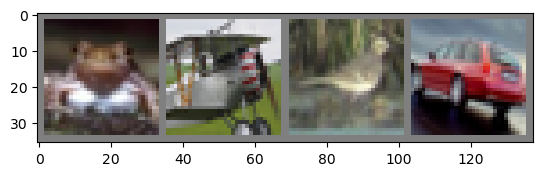

In [65]:
# show images
# getting 4 images as our batch size is 4
imshow(torchvision.utils.make_grid(images))

In [66]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer

model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

In [67]:
model = model.to(device)

In [68]:
criterion = nn.CrossEntropyLoss()

In [69]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [2000/12500], Loss: 3.1303
Epoch [1/5], Step [4000/12500], Loss: 2.0435
Epoch [1/5], Step [6000/12500], Loss: 1.2453
Epoch [1/5], Step [8000/12500], Loss: 0.8574
Epoch [1/5], Step [10000/12500], Loss: 0.8416
Epoch [1/5], Step [12000/12500], Loss: 1.1198
Epoch [2/5], Step [2000/12500], Loss: 1.8774
Epoch [2/5], Step [4000/12500], Loss: 0.4842
Epoch [2/5], Step [6000/12500], Loss: 1.3314
Epoch [2/5], Step [8000/12500], Loss: 1.9056
Epoch [2/5], Step [10000/12500], Loss: 1.1930
Epoch [2/5], Step [12000/12500], Loss: 1.5601
Epoch [3/5], Step [2000/12500], Loss: 1.5385
Epoch [3/5], Step [4000/12500], Loss: 0.2733
Epoch [3/5], Step [6000/12500], Loss: 0.8164
Epoch [3/5], Step [8000/12500], Loss: 1.1095
Epoch [3/5], Step [10000/12500], Loss: 0.3496
Epoch [3/5], Step [12000/12500], Loss: 0.5136
Epoch [4/5], Step [2000/12500], Loss: 1.2197
Epoch [4/5], Step [4000/12500], Loss: 1.2154
Epoch [4/5], Step [6000/12500], Loss: 0.6665
Epoch [4/5], Step [8000/12500], Loss: 0.7960
Epoc

In [ ]:
print('Finished Training')
PATH = './transfer_learning.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')
